# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [5]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,15.0,8.0,8.0,8.0,8.0,8.0,22.0,22.0,8.0,22.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,17.0,16.0,16.0,16.0,16.0,7.0,7.0,16.0,7.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
DIVERTED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [6]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [7]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [8]:
def regression_model(from_li, to_node):
    '''
    return OLS regression model, given list from_li of nodes and singular to_node
    '''
    X = train_df[from_li]
    y = train_df[to_node]
    model = sm.OLS(y, X).fit()
    return model

def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    
    # check to see if there are cycles, print one cycle if there exists at least one
    try:
        print(nx.find_cycle(bn, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
        
    return flight_edges_df, bn

def draw_graph(df,name):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    saves to name
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.savefig('./images/'+ name)
    plt.show()
    
def remove_edge(from_edge,to_edge,df):
    '''
    remove from_edge to to_edge directed edge from df
    '''
    # remove edge from df
    df = df[(flight_edges_df.from_node != from_edge) | (flight_edges_df.to_node != to_edge)]
    
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())
    # check for cycles
    try:
        print(nx.find_cycle(G, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
    return df, G

### ARR_DEL15

In [9]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     317.6
Date:                Thu, 05 Apr 2018   Prob (F-statistic):          3.64e-204
Time:                        23:48:20   Log-Likelihood:                -369.64
No. Observations:                 774   AIC:                             751.3
Df Residuals:                     768   BIC:                             779.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0153      0.001     11.421      0.000       0.013       0.018
DEP_DELAY              -0.0040      0.001     -4.667      0.000      -0.006      -0.002
CRS_ARR_TIME            0.0093      0.001      6.387      0.000       0.006       0.012
CARRIER_DELAY           0.0070      0.001      7.225      0.000       0.005       0.009
NAS_DELAY               0.0136      0.001     16.801      0.000       0.012       0.015
LATE_AIRCRAFT_DELAY     0.0126      0.001     10.323      0.000       0.010       0.015
==============================================================================
Omnibus:                       19.536   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.769
Skew:                          -0.243   Prob(JB):                     9.33e-07
Kurtosis:                       3.791   Cond. No.                         8.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


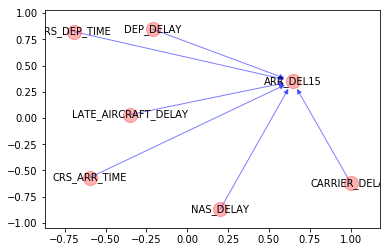

In [10]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [11]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     151.0
Date:                Thu, 05 Apr 2018   Prob (F-statistic):          4.31e-163
Time:                        23:48:20   Log-Likelihood:                -3060.0
No. Observations:                 774   AIC:                             6138.
Df Residuals:                     765   BIC:                             6180.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -1.9719      0.411     -4.793      0.000      -2.779      -1.164
CRS_DEP_TIME           -0.6616      0.066    -10.046      0.000      -0.791      -0.532
DEP_DELAY               0.6601      0.028     23.430      0.000       0.605       0.715
TAXI_OUT                0.8475      0.042     20.348      0.000       0.766       0.929
TAXI_IN                 0.8501      0.052     16.335      0.000       0.748       0.952
CRS_ARR_TIME           -0.7577      0.076    -10.000      0.000      -0.906      -0.609
DIVERTED            -4.045e-16   2.42e-17    -16.697      0.000   -4.52e-16   -3.57e-16
CARRIER_DELAY          -0.6680      0.031    -21.535      0.000      -0.729      -0.607
WEATHER_DELAY          -0.6036      0.080     -7.518      0.000      -0.761      -0.446
LATE_AIRCRAFT_DELAY    -0.7173      0.039    -18.522      0.000      -0.793      -0.641
==============================================================================
Omnibus:                      145.374   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.833
Skew:                           0.995   Prob(JB):                     2.94e-76
Kurtosis:                       5.612   Cond. No.                     7.82e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.34e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


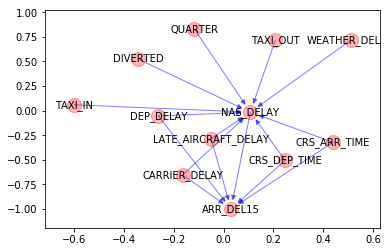

In [13]:
draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [14]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
regression_model(late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.749
Model:                             OLS   Adj. R-squared:                  0.747
Method:                  Least Squares   F-statistic:                     457.8
Date:                 Thu, 05 Apr 2018   Prob (F-statistic):          1.13e-227
Time:                         23:48:21   Log-Likelihood:                -2953.4
No. Observations:                  774   AIC:                             5917.
Df Residuals:                      769   BIC:                             5940.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.2951      0.057      5.132      0.000       0.182       0.408
DEP_DELAY         0.6161      0.014     44.718      0.000       0.589       0.643
CARRIER_DELAY    -0.6267      0.018    -34.408      0.000      -0.662      -0.591
WEATHER_DELAY    -0.6250      0.067     -9.334      0.000      -0.756      -0.494
NAS_DELAY        -0.2379      0.021    -11.270      0.000      -0.279      -0.196
==============================================================================
Omnibus:                      309.451   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9528.851
Skew:                          -1.162   Prob(JB):                         0.00
Kurtosis:                      20.031   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [16]:
# remove both edges
flight_edges_df, _ = remove_edge('NAS_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY','NAS_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [17]:
carrier_delay_from = ['CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(carrier_delay_from, 'CARRIER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     934.3
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:48:21   Log-Likelihood:                -2998.3
No. Observations:                 774   AIC:                             6013.
Df Residuals:                     766   BIC:                             6050.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME           -0.6161      0.057    -10.818      0.000      -0.728      -0.504
DEP_DELAY               0.8912      0.011     83.683      0.000       0.870       0.912
TAXI_OUT                0.5913      0.040     14.648      0.000       0.512       0.671
TAXI_IN                 0.5683      0.051     11.128      0.000       0.468       0.668
CRS_ARR_TIME           -0.7833      0.065    -12.000      0.000      -0.911      -0.655
DIVERTED             3.442e-15   2.35e-16     14.674      0.000    2.98e-15     3.9e-15
WEATHER_DELAY          -0.8440      0.070    -11.981      0.000      -0.982      -0.706
NAS_DELAY              -0.5553      0.026    -21.321      0.000      -0.606      -0.504
LATE_AIRCRAFT_DELAY    -0.9726      0.024    -39.928      0.000      -1.020      -0.925
==============================================================================
Omnibus:                      215.464   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8013.569
Skew:                          -0.504   Prob(JB):                         0.00
Kurtosis:                      18.731   Cond. No.                     3.54e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [19]:
# remove both edges
flight_edges_df, _ = remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]
[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

In [20]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)

No cycle found! You may proceed.


### WEATHER_DELAY

Though not ideal in p-value, CRS_DEP_TIME seems like the only likely variable which WEATHER_DELAY may be dependent on.

In [21]:
weather_delay_from = ['CRS_DEP_TIME']
regression_model(weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.791
Date:                Thu, 05 Apr 2018   Prob (F-statistic):             0.0952
Time:                        23:48:21   Log-Likelihood:                -2489.4
No. Observations:                 774   AIC:                             4981.
Df Residuals:                     773   BIC:                             4985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CRS_DEP_TIME     0.0239      0.014      1.671      0.095      -0.004       0.052
==============================================================================
Omnibus:                     2019.192   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18110032.665
Skew:                          27.213   Prob(JB):                         0.00
Kurtosis:                     750.388   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

No cycle found! You may proceed.


### Security Delay

Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

In [23]:
security_delay_from = ['DAY_OF_WEEK','DEP_DELAY','TAXI_OUT','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(security_delay_from, 'SECURITY_DELAY').summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1388: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1432: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:660: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:47: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SECURITY_DELAY   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 05 Apr 2018   Prob (F-statistic):                nan
Time:                        23:48:21   Log-Likelihood:                    inf
No. Observations:                 774   AIC:                              -inf
Df Residuals:                     768   BIC:                              -inf
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
DAY_OF_WEEK                  0          0        nan        nan           0           0
DEP_DELAY                    0          0        nan        nan           0           0
TAXI_OUT                     0          0        nan        nan           0           0
CARRIER_DELAY                0          0        nan        nan           0           0
NAS_DELAY                    0          0        nan        nan           0           0
LATE_AIRCRAFT_DELAY          0          0        nan        nan           0           0
==============================================================================
Omnibus:                        1.007   Durbin-Watson:                     nan
Prob(Omnibus):                  0.604   Jarque-Bera (JB):              290.250
Skew:                           0.000   Prob(JB):                     9.40e-64
Kurtosis:                       0.000   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
flight_edges_df, bn = update_flights_edges_df(security_delay_from, 'SECURITY_DELAY',flight_edges_df)

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [25]:
quarter_from = ['MONTH','CRS_DEP_TIME','CRS_ARR_TIME']
regression_model(quarter_from, 'QUARTER').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.744e+04
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:48:21   Log-Likelihood:                -101.05
No. Observations:                 774   AIC:                             208.1
Df Residuals:                     771   BIC:                             222.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3239      0.003    112.963      0.000       0.318       0.329
CRS_DEP_TIME     0.0105      0.001      8.934      0.000       0.008       0.013
CRS_ARR_TIME     0.0179      0.001     14.913      0.000       0.016       0.020
==============================================================================
Omnibus:                     1182.451   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.143
Skew:                           0.030   Prob(JB):                     2.88e-12
Kurtosis:                       1.718   Cond. No.                         6.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

In [27]:
departure_delay_from = ['QUARTER','MONTH','DAY_OF_WEEK','CRS_DEP_TIME','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     1246.
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:48:21   Log-Likelihood:                -3038.0
No. Observations:                 774   AIC:                             6098.
Df Residuals:                     763   BIC:                             6149.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 4.8551      1.622      2.993      0.003       1.671       8.039
MONTH                  -1.3333      0.539     -2.476      0.014      -2.391      -0.276
DAY_OF_WEEK             0.4790      0.217      2.205      0.028       0.052       0.905
CRS_DEP_TIME            0.6028      0.068      8.848      0.000       0.469       0.736
TAXI_OUT               -0.7302      0.043    -17.017      0.000      -0.814      -0.646
TAXI_IN                -0.6644      0.054    -12.345      0.000      -0.770      -0.559
CRS_ARR_TIME            0.7824      0.079      9.854      0.000       0.627       0.938
DIVERTED             2.644e-16   1.43e-16      1.845      0.065   -1.69e-17    5.46e-16
CARRIER_DELAY           1.0115      0.012     84.412      0.000       0.988       1.035
WEATHER_DELAY           0.9514      0.074     12.884      0.000       0.806       1.096
NAS_DELAY               0.6307      0.027     23.477      0.000       0.578       0.683
LATE_AIRCRAFT_DELAY     1.1018      0.022     49.207      0.000       1.058       1.146
==============================================================================
Omnibus:                      305.218   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3317.069
Skew:                           1.464   Prob(JB):                         0.00
Kurtosis:                      12.710   Cond. No.                     1.94e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.75e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


It is not very likely that an NAS-related delay causes a security-related delay. Therefore, we will remove the edge from NAS_DELAY to SECURITY_DELAY.

In [29]:
flight_edges_df, bn = remove_edge('NAS_DELAY','SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [30]:
flight_edges_df, bn = remove_edge('NAS_DELAY','DEP_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Departure delay cannot lead to a late aircraft delay: this is temporally impossible, so we get rid of that directed edge.

In [31]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


Again, temporally, departure delay cannot lead to a carrier delay. Therefore, we remove that directed edge.

In [32]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

No cycle found! You may proceed.


By the same reasoning as above, we remove the edge from DEP_DELAY to SECURITY_DELAY.

In [33]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'SECURITY_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [34]:
taxi_out_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_IN','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     938.6
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:48:21   Log-Likelihood:                -2783.0
No. Observations:                 774   AIC:                             5584.
Df Residuals:                     765   BIC:                             5626.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 2.3411      0.279      8.379      0.000       1.793       2.890
CRS_DEP_TIME            0.7723      0.040     19.187      0.000       0.693       0.851
DEP_DELAY              -0.3732      0.022    -16.958      0.000      -0.416      -0.330
TAXI_IN                -0.3928      0.040     -9.869      0.000      -0.471      -0.315
CRS_ARR_TIME            0.9493      0.045     21.250      0.000       0.862       1.037
CARRIER_DELAY           0.3590      0.024     14.815      0.000       0.311       0.407
WEATHER_DELAY           0.2917      0.057      5.098      0.000       0.179       0.404
NAS_DELAY               0.4143      0.020     20.348      0.000       0.374       0.454
LATE_AIRCRAFT_DELAY     0.3513      0.030     11.707      0.000       0.292       0.410
==============================================================================
Omnibus:                       29.152   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.194
Skew:                           0.392   Prob(JB):                     1.38e-08
Kurtosis:                       3.713   Cond. No.                         56.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [36]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [37]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [38]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [39]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'NAS_DELAY', flight_edges_df)

[('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [40]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [41]:
taxi_in_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     133.6
Date:                Thu, 05 Apr 2018   Prob (F-statistic):          2.29e-150
Time:                        23:48:21   Log-Likelihood:                -2662.3
No. Observations:                 774   AIC:                             5343.
Df Residuals:                     765   BIC:                             5384.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 1.1231      0.246      4.558      0.000       0.639       1.607
CRS_DEP_TIME            0.3574      0.040      8.963      0.000       0.279       0.436
DEP_DELAY              -0.2468      0.020    -12.216      0.000      -0.286      -0.207
TAXI_OUT               -0.2875      0.029     -9.869      0.000      -0.345      -0.230
CRS_ARR_TIME            0.4917      0.045     10.976      0.000       0.404       0.580
DIVERTED             1.698e-15   2.27e-16      7.468      0.000    1.25e-15    2.14e-15
CARRIER_DELAY           0.2480      0.022     11.410      0.000       0.205       0.291
WEATHER_DELAY           0.2159      0.049      4.392      0.000       0.119       0.312
NAS_DELAY               0.3042      0.019     16.335      0.000       0.268       0.341
LATE_AIRCRAFT_DELAY     0.2694      0.026     10.313      0.000       0.218       0.321
==============================================================================
Omnibus:                     1016.178   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           295545.114
Skew:                           6.536   Prob(JB):                         0.00
Kurtosis:                      97.833   Cond. No.                     1.36e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.77e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [43]:
flight_edges_df, bn = remove_edge('TAXI_OUT','DEP_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [44]:
flight_edges_df, bn = remove_edge('TAXI_IN','NAS_DELAY', flight_edges_df)

[('TAXI_IN', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [45]:
flight_edges_df, bn = remove_edge('TAXI_IN','CARRIER_DELAY', flight_edges_df)

[('TAXI_IN', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [46]:
flight_edges_df, bn = remove_edge('TAXI_IN','DEP_DELAY', flight_edges_df)

[('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'TAXI_OUT')]


In [47]:
flight_edges_df, bn = remove_edge('TAXI_IN','TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [48]:
delayed_SFO_from = ['WEATHER_DELAY','ScheduledDepartureSFO','DelayedArrivalPHL','ScheduledArrivalPHL']
regression_model(delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.722
Model:                             OLS   Adj. R-squared:                  0.720
Method:                  Least Squares   F-statistic:                     499.0
Date:                 Thu, 05 Apr 2018   Prob (F-statistic):          4.36e-212
Time:                         23:48:21   Log-Likelihood:                -1676.6
No. Observations:                  774   AIC:                             3361.
Df Residuals:                      770   BIC:                             3380.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WEATHER_DELAY             0.0270      0.013      2.087      0.037       0.002       0.052
ScheduledDepartureSFO     0.1382      0.004     31.325      0.000       0.130       0.147
DelayedArrivalPHL         0.4178      0.047      8.836      0.000       0.325       0.511
ScheduledArrivalPHL      -0.0381      0.014     -2.717      0.007      -0.066      -0.011
==============================================================================
Omnibus:                      205.117   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              805.667
Skew:                           1.192   Prob(JB):                    1.13e-175
Kurtosis:                       7.393   Cond. No.                         14.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [50]:
delayed_PHL_from = ['CRS_DEP_TIME','WEATHER_DELAY','DelayedDepartureSFO','ScheduledDepartureSFO','ScheduledArrivalPHL']
regression_model(delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     654.3
Date:                Thu, 05 Apr 2018   Prob (F-statistic):          3.75e-274
Time:                        23:48:21   Log-Likelihood:                -1424.0
No. Observations:                 774   AIC:                             2858.
Df Residuals:                     769   BIC:                             2881.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CRS_DEP_TIME             -0.0139      0.004     -3.165      0.002      -0.023      -0.005
WEATHER_DELAY             0.0502      0.009      5.458      0.000       0.032       0.068
DelayedDepartureSFO       0.2179      0.025      8.785      0.000       0.169       0.267
ScheduledDepartureSFO    -0.0390      0.005     -8.323      0.000      -0.048      -0.030
ScheduledArrivalPHL       0.2455      0.006     42.551      0.000       0.234       0.257
==============================================================================
Omnibus:                      435.221   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6471.618
Skew:                           2.210   Prob(JB):                         0.00
Kurtosis:                      16.459   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('DelayedDepartureSFO', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'DelayedDepartureSFO')]


In [52]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL','DelayedDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


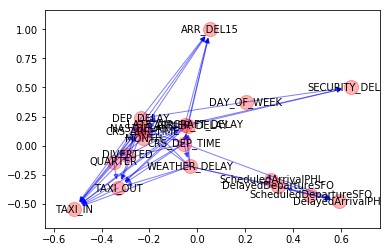

In [53]:
draw_graph(flight_edges_df,'final_bn.png')

In [54]:
nx.is_directed_acyclic_graph(bn), nx.is_tree(bn)

(True, False)

There are 19 nodes and 59 directed edges in this DAG.

## Graph Visualization

In [55]:
from IPython.display import Javascript
import json